## Import

In [1]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Real Measurment

In [2]:
datafile = '2014-04-23-GNSSGroundTruth.csv'

LatDD, LonDD = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)



Read '2014-04-23-GNSSGroundTruth.csv' successfully.


## Input Parameters

In [3]:
dt    = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS = 1.0/10.0 # Sample Rate of GPS is 10Hz
numstates = 6

## Matrices

In [4]:
vs, psis, dpsis, dts, xs, ys, axs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v \psi \dot\psi T x y a_x \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+(vs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))],
             [vs + axs*dts],
             [psis+dpsis*dts],
             [phis+dphis*dts],
             [thetas+dthetas*dts]])
state = Matrix([xs,ys,vs,psis,phis,thetas])

### Dynamic Matrix

In [5]:
As

⎡    v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))⎤
⎢x + ───────────────────────────────────────⎥
⎢                    \dot\psi               ⎥
⎢                                           ⎥
⎢    v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi)) ⎥
⎢y + ────────────────────────────────────── ⎥
⎢                   \dot\psi                ⎥
⎢                                           ⎥
⎢                 T⋅aₓ + v                  ⎥
⎢                                           ⎥
⎢             T⋅\dot\psi + \psi             ⎥
⎢                                           ⎥
⎢             T⋅\dot\phi + \phi             ⎥
⎢                                           ⎥
⎣           T⋅\dot\Theta + \Theta           ⎦

In [6]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

### Jacobian of the Dynamic Matrix with respect to the state vector

In [7]:
As.jacobian(state)

⎡      -sin(\psi) + sin(T⋅\dot\psi + \psi)  v⋅(-cos(\psi) + cos(T⋅\dot\psi + \
⎢1  0  ───────────────────────────────────  ──────────────────────────────────
⎢                    \dot\psi                               \dot\psi          
⎢                                                                             
⎢      cos(\psi) - cos(T⋅\dot\psi + \psi)   v⋅(-sin(\psi) + sin(T⋅\dot\psi + \
⎢0  1  ──────────────────────────────────   ──────────────────────────────────
⎢                   \dot\psi                                \dot\psi          
⎢                                                                             
⎢0  0                   1                                      0              
⎢                                                                             
⎢0  0                   0                                      1              
⎢                                                                             
⎢0  0                   0                           

### Control Input

In [8]:
control = Matrix([axs, dpsis, dphis, dthetas])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢ \dot\psi ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎣\dot\Theta⎦

### Jacobian of the Dynamic Matirx with respect to the control input

In [9]:
JGs = As.jacobian(control)
JGs

⎡   T⋅v⋅cos(T⋅\dot\psi + \psi)   v⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))      
⎢0  ────────────────────────── - ───────────────────────────────────────  0  0
⎢            \dot\psi                                   2                     
⎢                                               \dot\psi                      
⎢                                                                             
⎢   T⋅v⋅sin(T⋅\dot\psi + \psi)   v⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))       
⎢0  ────────────────────────── - ──────────────────────────────────────   0  0
⎢            \dot\psi                                  2                      
⎢                                              \dot\psi                       
⎢                                                                             
⎢T                                   0                                    0  0
⎢                                                                             
⎢0                                   T              

## Read Data

In [10]:
datafile = '2014-04-23-GPS-IMU-Data.csv'

date, \
timem, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2014-04-23-GPS-IMU-Data.csv' successfully.


In [11]:
print(len(epe))
epe = (np.zeros(epe.shape)+1)*2

6014


In [12]:

# v0 = 0 
# cvX = []
# # cvX.append(v0)
# cvY = []
# # cvY.append(v0)
# for i in range(len(ax)):
#     if i == 0: 
#         vx = v0 + ax[i]*dt
#         vy = v0 + ay[i]*dt
#     else: 
#         vx = vx + ax[i]*dt
#         vy = vy + ay[i]*dt
#     cvX.append(vx)
#     cvY.append(vy)
# print(len(cvX))
# print(len(ax))
# # print(cvY)



# p0 = 0 
# cpX = []
# cpY = []

# for i in range(len(ax)):
#     if i == 0: 
#         px = p0 + cvX[i]*dt + (1/2)*ax[i]*dt
#         py = p0 + cvY[i]*dt + (1/2)*ay[i]*dt

#     else: 
#         px = px + cvX[i]*dt + (1/2)*ax[i]*dt
#         py = py + cvY[i]*dt + (1/2)*ay[i]*dt

#     cpX.append(px)
#     cpY.append(py)

# print(len(cpX))
# vel = []
# for i in range(len(ax)):
#     if i == 0:
#         dist = np.sqrt((cpX[i]**2)+ (cpY[i]**2))/dt
#     else: 
#         dist = np.sqrt((cpX[i]**2 - cpX[i-1]**2) + (cpX[i]**2 - cpX[i-1]**2))/dt
#     vel.append(dist)

# print(vel)

## Static Gain

In [13]:
ax = ax + 0.5
rollrate = rollrate + 1.42
yawrate = yawrate + 0.07
pitchrate = pitchrate + 2.17

## Process Noise Covariance Matrix Q

In [14]:
jerkmax = 300.0    # m/s3

pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

In [15]:
Q = np.diagflat([[(dt * jerkmax)**2],            # acceleration
            [(dt * yawrateaccmax)**2],           # yawrate
            [(dt * pitchrateaccmax)**2],         # pitchrate
            [(dt * rollrateaccmax)**2]])         # rollrate

## Lat/Lon to Meters

In [16]:
R = 6378388.0 + altitude # m
arc= 2.0*np.pi*R/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m


mx = np.cumsum(dx)
my = np.cumsum(dy)

ds = np.sqrt(dx**2+dy**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter

In [17]:
print(len(ay))
print(len(dx))

6014
6014


In [18]:
# print(GPS[0:20])
k = 0
xsum = 0
ysum = 0 
sxsum = 0
sysum = 0 
gx = []
gy = []

prevX = 0 
prevY = 0
addX = 0
addY = 0 

gbool = []
cspeed = []
s = 0 
sped = 1 
spedd = 0 
for i in range(len(GPS)):
#     print("speed")

    if sped == 1: 
#         print("update speed")
        sped = 0 
        spedd = speed[i]
    if GPS[i]:
#         print("GPS")
        
        if k == 0: 
            gb = True
            sped = 1
#             print(sped)
            prevX = prevX + addX + dx[i]
            prevY = prevY + addY + dy[i]
            addX = 0
            addY = 0 
            k = 10

        else:
            gb = False
            addX = addX + dx[i]
            addY = addY + dy[i]
            k = k - 1
    else: 
        gb = False
#     print(spedd)
    gx.append(prevX)
    gy.append(prevY)
    gbool.append(gb)
    cspeed.append(spedd)
            
# print(gbool)
# print(gx)

dtGPS = 0.5 # Sample Rate of GPS is 10Hz
GPS = gbool 
mx = gx
my = gy 
speed = np.array(cspeed)
# print(np.array(cspeed[0:15]))
# print(speed[0:15])
# print(cspeed[0:10])
# print(speed[0:10])

In [19]:
# cspeed = []
# for i in range(len(dx)):
    
#     if GPS[i]:
# #         print(dx[i])
# #         print(dy[i])
# #         print(np.sqrt(dx[i]**2 + dy[i]**2)/dt)
#         sped = np.sqrt(dx[i]**2 + dy[i]**2)/dt
#     cspeed.append(sped)
        
# if cspeed[0] == 0:
#     cspeed[0] = cspeed[2]
#     cspeed[1] = cspeed[2]
# print(len(cspeed))

# cspeed = np.array(cspeed)#-10
# print(cspeed[0:20])
# print(speed[0:20])

In [20]:
print('One degree of Lon is %.2fkm at %.1fm altitude.' % (arc[0]/1000.0, altitude[0]))

One degree of Lon is 111.33km at 117.7m altitude.


## Measurement Noise Covariance Matrix R (Adaptive)

In [21]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

In [53]:
print(min(dx))
print(max(dy))
print(max(speed))
print(min(pitch))
print(max(pitch))
print(min(pitchrate))
print(max(pitchrate))


-2.3797060581602336
2.22651676833133
51.6599
-23.0752
11.9081
-8.3343
5.37


In [22]:

R = np.diagflat([[(5.0)**2],      # x
            [(5.0)**2],           # y
            [(10.0)**2],  # v
            [(0.5)**2],  # heading 
            [(0.5)**2],  # pitch
            [(0.5)**2]]) # roll

### Position

In [55]:
epsilon = 0.1
xi      = 500.0
zeta    = 50.0
spspeed=xi/((speed/3.6)+epsilon)

#spspeed=xi/((speed/3.6)+epsilon)
spepe=zeta*epe
sp = (spspeed)**2 + (spepe)**2

print(spspeed)
print(sp)

[ 52.29517722  52.29517722  52.29517722 ... 547.11246201 547.11246201
 547.11246201]
[ 12734.78556074  12734.78556074  12734.78556074 ... 309332.04608235
 309332.04608235 309332.04608235]


### Attitude

In [24]:
print(ay)

[-0.0392 -0.5883 -0.3628 ... -0.5001 -0.6275 -0.3824]


In [25]:
rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

## Measurement Function h 

### If GPS measurment is available

In [26]:
hs = Matrix([[xs],[ys],[vs],[psis],[phis],[thetas]])
Hs=hs.jacobian(state)
Hs

⎡1  0  0  0  0  0⎤
⎢                ⎥
⎢0  1  0  0  0  0⎥
⎢                ⎥
⎢0  0  1  0  0  0⎥
⎢                ⎥
⎢0  0  0  1  0  0⎥
⎢                ⎥
⎢0  0  0  0  1  0⎥
⎢                ⎥
⎣0  0  0  0  0  1⎦

### Identity Matrix

In [27]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]] (6, 6)


## Initial State

[[0.        ]
 [0.        ]
 [9.46111111]
 [0.        ]
 [0.        ]
 [0.        ]] (6, 1)


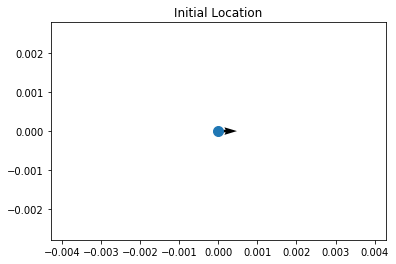

In [28]:
x = np.matrix([[mx[0], my[0], speed[0]/3.6, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

U=float(np.cos(x[3])*x[2])
V=float(np.sin(x[3])*x[2])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty

Initialized with $0$ means you are pretty sure where the vehicle starts and in which direction it is heading. Initialized with high values means, that you trust the measurements first, to align the state vector $x$ with them.

#### TODO: change this value

In [29]:
P = 1e5*np.eye(numstates)

## Measurement Vector

In [60]:
measurements = np.vstack((mx, my, \
                          speed/3.6, \
                          yaw/180.0*np.pi, \
                          pitch/180.0*np.pi, \
                          roll/180.0*np.pi))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

print(measurements)

(7, 6014)
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.77508687e+02
  -1.77508687e+02 -1.77508687e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.77447288e+02
   5.77447288e+02  5.77447288e+02]
 [ 9.46111111e+00  9.46111111e+00  9.46111111e+00 ...  8.13888889e-01
   8.13888889e-01  8.13888889e-01]
 ...
 [-1.38498857e+00 -1.38583157e+00 -1.38741458e+00 ...  1.04107145e+00
   1.04118489e+00  1.04063162e+00]
 [-7.36494038e-02 -8.42069004e-02 -8.60744027e-02 ... -2.27905094e-02
  -1.86244084e-02 -2.39232281e-02]
 [ 3.09237437e-02  3.51038072e-02  3.34823964e-02 ...  4.81745780e-02
   4.79232506e-02  4.32667122e-02]]


In [31]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
dstate=[]

## Extended Kalman Filter Step

In [32]:
for filterstep in range(m):

    axc = -ax[filterstep]
    yawc = yawrate[filterstep]/180.0*np.pi
    pitc = pitchrate[filterstep]/180.0*np.pi
    rolc = rollrate[filterstep]/180.0*np.pi
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    # see "Dynamic Matrix"
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[2]*dt * np.cos(x[3])
        x[1] = x[1] + x[2]*dt * np.sin(x[3])
        x[2] = x[2] + axc*dt
        x[3] = x[3]
        x[4] = x[4] + pitc*dt
        x[5] = x[5] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[2]/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3]))
        x[1] = x[1] + (x[2]/yawc) * (-np.cos(yawc*dt+x[3])+ np.cos(x[3]))
        x[2] = x[2] + axc*dt
        x[3] = (x[3] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[4] = x[4] + pitc*dt
        x[5] = x[5] + rolc*dt
        dstate.append(1)
    
    
    # Calculate the Jacobian of the Dynamic Matrix A
    # see "Calculate the Jacobian of the Dynamic Matrix with respect to the state vector"
    a13 = float((1.0/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3])))
    a14 = float((x[2]/yawc)* (np.cos(yawc*dt+x[3]) - np.cos(x[3])))
    a23 = float((1.0/yawc) * (-np.cos(yawc*dt+x[3]) + np.cos(x[3])))
    a24 = float(x[2]/yawc) * (np.sin(yawc*dt+x[3]) - np.sin(x[3]))
    JA = np.matrix([[1.0, 0.0, a13, a14, 0.0, 0.0],
                  [0.0, 1.0, a23, a24, 0.0, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Calculate the Jacobian of the Control Input G
    # see "Calculate the Jacobian of the Dynamic Matrix with Respect to the Control"
    g12 = float((dt*x[2]/yawc)*np.cos(yawc*dt+x[3]) - x[2]/yawc**2*(np.sin(yawc*dt+x[3])-np.sin(x[3])))
    g22 = float((dt*x[2]/yawc)*np.sin(yawc*dt+x[3]) - x[2]/yawc**2*(-np.cos(yawc*dt+x[3])+np.cos(x[3])))
    JG = np.matrix([[0.0, g12, 0.0, 0.0],
                    [0.0, g22, 0.0, 0.0],
                    [dt, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, dt]])
 
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    else:
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Adaptive R
    R[0,0] = sp[filterstep]       # x
    R[1,1] = sp[filterstep]       # y
    R[2,2] = spspeed[filterstep]  # v
    R[3,3] = syaw[filterstep]  # course
    R[4,4] = spitch[filterstep]   # pitch
    R[5,5] = sroll[filterstep]    # roll
    

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    z = measurements[:,filterstep].reshape(JH.shape[0],1)
    y = z - (hx)                         # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*JH))*P
    

    # Save states for Plotting
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))

    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    
    #Zx.append(float(z[0]))
    #Zy.append(float(z[1]))    
    
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))

## Plots

In [33]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Uncertainties of Matrix P 

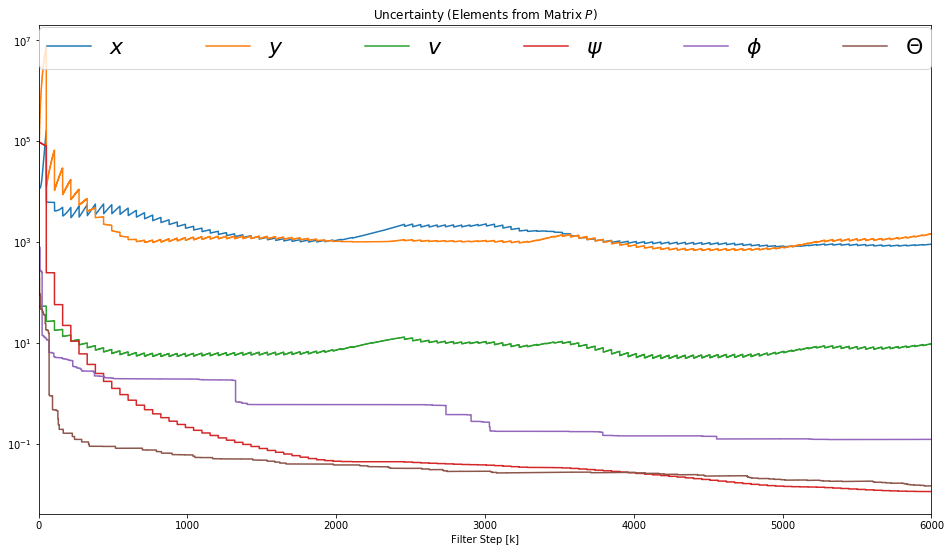

In [34]:
fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),P0, label='$x$')
plt.step(range(m),P1, label='$y$')
plt.step(range(m),P2, label='$v$')
plt.step(range(m),P3, label='$\psi$')
plt.step(range(m),P4, label='$\phi$')
plt.step(range(m),P5, label='$\Theta$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Uncertainty (Elements from Matrix $P$)')
#plt.legend(loc='best',prop={'size':22})
plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
       ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')

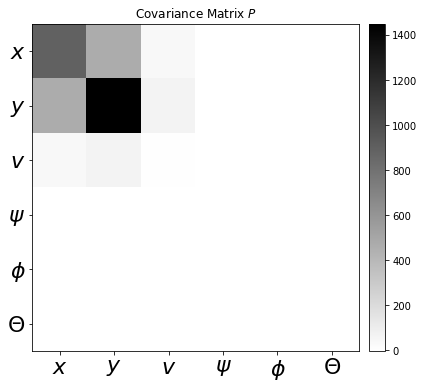

In [35]:
fig = plt.figure(figsize=(numstates, numstates))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(7))
# set the locations and labels of the yticks
plt.yticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(7))
# set the locations and labels of the yticks
plt.xticks(np.arange(6), \
           ('$x$', '$y$', '$v$', '$\psi$', '$\phi$', '$\Theta$'),\
           fontsize=22)

plt.xlim([-0.5,5.5])
plt.ylim([5.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)

plt.tight_layout()

## Kalman Gains in K

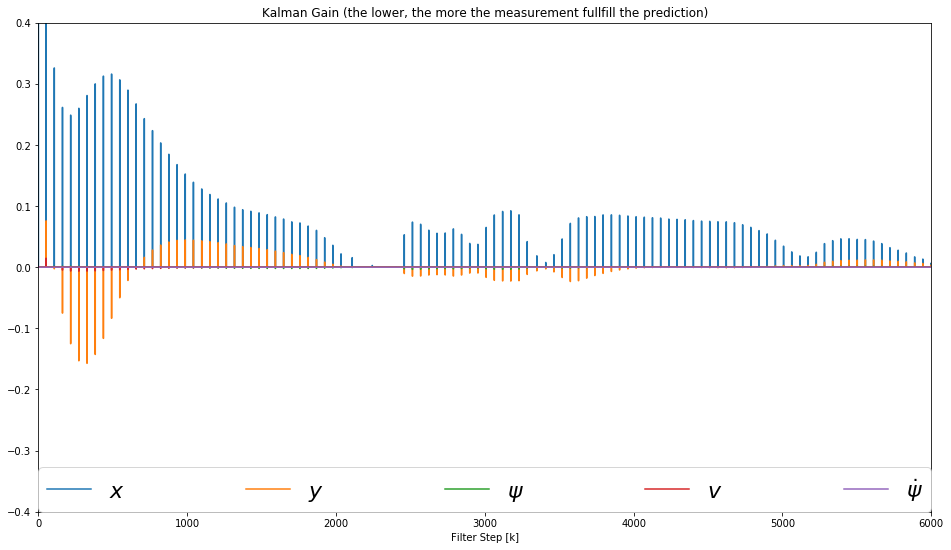

In [36]:
fig = plt.figure(figsize=(16,9))
plt.step(range(len(measurements[0])),K0, label='$x$')
plt.step(range(len(measurements[0])),K1, label='$y$')
plt.step(range(len(measurements[0])),K2, label='$\psi$')
plt.step(range(len(measurements[0])),K3, label='$v$')
plt.step(range(len(measurements[0])),K4, label='$\dot \psi$')

plt.xlabel('Filter Step [k]')
plt.ylabel('')
plt.xlim(0,6000)
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
#plt.legend(prop={'size':18})
plt.legend(bbox_to_anchor=(0., 0., 1., .102), loc=3,
       ncol=5, mode="expand", borderaxespad=0.,prop={'size':22})
plt.ylim([-0.4,0.4])

## State Vector

In [37]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  v   ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢ \phi ⎥
⎢      ⎥
⎣\Theta⎦

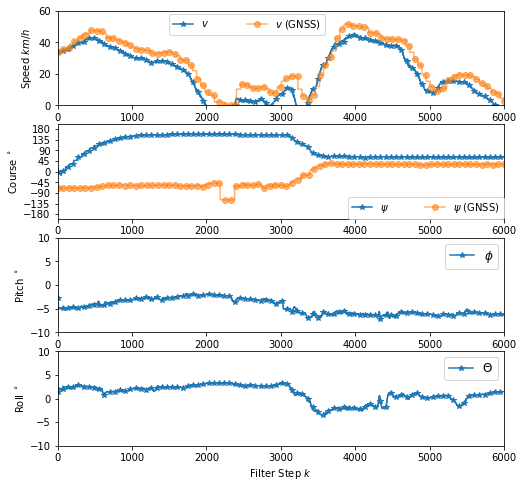

In [38]:
fig = plt.figure(figsize=(8,numstates+2))

# Speed
plt.subplot(411)
plt.step(range(len(measurements[0])),np.multiply(x2,3.6), label='$v$', marker='*', markevery=140)
plt.step(range(len(measurements[0])),speed, label='$v$ (GNSS)', marker='o', markevery=150, alpha=0.6)
plt.ylabel('Speed $km/h$')
plt.xlim(0,6000)
#plt.yticks(np.arange(-180, 181, 45))
plt.ylim([0,60])
plt.legend(bbox_to_anchor=(0.25, 0.75, 0.35, .06), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

# Course
plt.subplot(412)
plt.step(range(len(measurements[0])),np.multiply(x3,180.0/np.pi), label='$\psi$', marker='*', markevery=140)
plt.step(range(len(measurements[0])),(course+180.0)%(360.0)-180.0, label='$\psi$ (GNSS)', marker='o', markevery=150, alpha=0.6)
plt.ylabel('Course $^\circ$')
plt.yticks(np.arange(-180, 181, 45))
plt.ylim([-200,200])
plt.xlim(0,6000)
plt.legend(bbox_to_anchor=(0.65, 0.0, 0.35, .06), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
#plt.title('State Estimates $x_k$')

# Pitch
plt.subplot(413)
plt.step(range(len(measurements[0])),np.multiply(x4,180.0/np.pi), label='$\phi$', marker='*', markevery=140)
plt.ylabel('Pitch $^\circ$')
plt.ylim([-10.0, 10.0])
plt.xlim(0,6000)
plt.legend(loc='best',prop={'size':12})

# Roll
plt.subplot(414)
plt.step(range(len(measurements[0])),np.multiply(x5,180.0/np.pi), label='$\Theta$', marker='*', markevery=140)
plt.ylabel('Roll $^\circ$')
plt.ylim([-10.0, 10.0])
plt.xlim(0,6000)
plt.legend(loc='best',prop={'size':12})

plt.xlabel('Filter Step $k$')

plt.savefig('Extended-Kalman-Filter-CTRV-Attitude-State-Estimates.eps', bbox_inches='tight')

## Convert back from Meters to Lat/Lon 

In [39]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))

## Position Lat/Lon

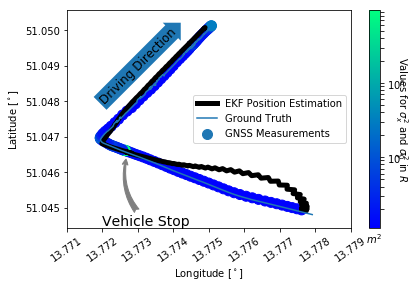

In [40]:
whratio = np.cos(np.mean(latitude*np.pi/180.0))
fh = 4.0
fig = plt.figure(figsize=(fh/whratio, fh))

# EKF State
plt.plot(lonekf,latekf, label='EKF Position Estimation', color='k', linewidth=5)

# Ground Truth
plt.plot(LonDD,LatDD, label='Ground Truth')

# Low Cost GPS Measurements
plt.scatter(longitude[::50],latitude[::50], s=100, label='GNSS Measurements',\
            c=sp[::50], cmap='winter', norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel(u'Values for $\sigma_x^2$ and $\sigma_y^2$ in $R$', rotation=270)
cbar.ax.set_xlabel(u'$m^2$')

# Annotations
bbox_props = dict(boxstyle="rarrow,pad=0.3", ec="w", lw=2)
t = plt.text(13.773, 51.049, "Driving Direction", ha="center", va="center", rotation=45,
            size=12,
            bbox=bbox_props)


plt.annotate("Vehicle Stop",
            xy=(13.7727, 51.0465), xycoords='data',
            xytext=(13.772, 51.0445), textcoords='data',
            size=14,
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=5,
                            connectionstyle="arc3,rad=-0.3",
                            ),
            )

plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
#plt.title('Position of EKF state $x_k$, GNSS measurements and uncertainty $R$ (color)')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

#plt.xlim(13.7865, 13.7880)
#plt.ylim(51.0265, 51.0285)

# xticks
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%.3f" % x, locs))
plt.xticks(rotation=35)

# ytikcs
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.3f" % x, locs))

#plt.show()
plt.savefig('Extended-Kalman-Filter-CTRV-Position.eps', bbox_inches='tight')

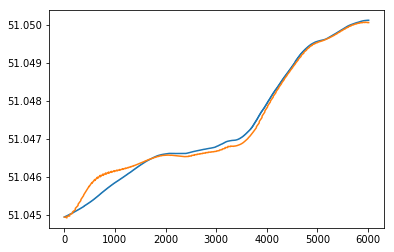

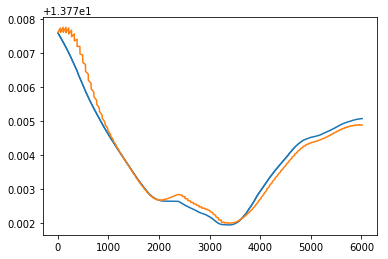

In [41]:
plt.plot(latitude)
plt.plot(latekf)
plt.show()

plt.plot(longitude)
plt.plot(lonekf)
plt.show()

## 3D plot

NameError: name 'AltDD' is not defined

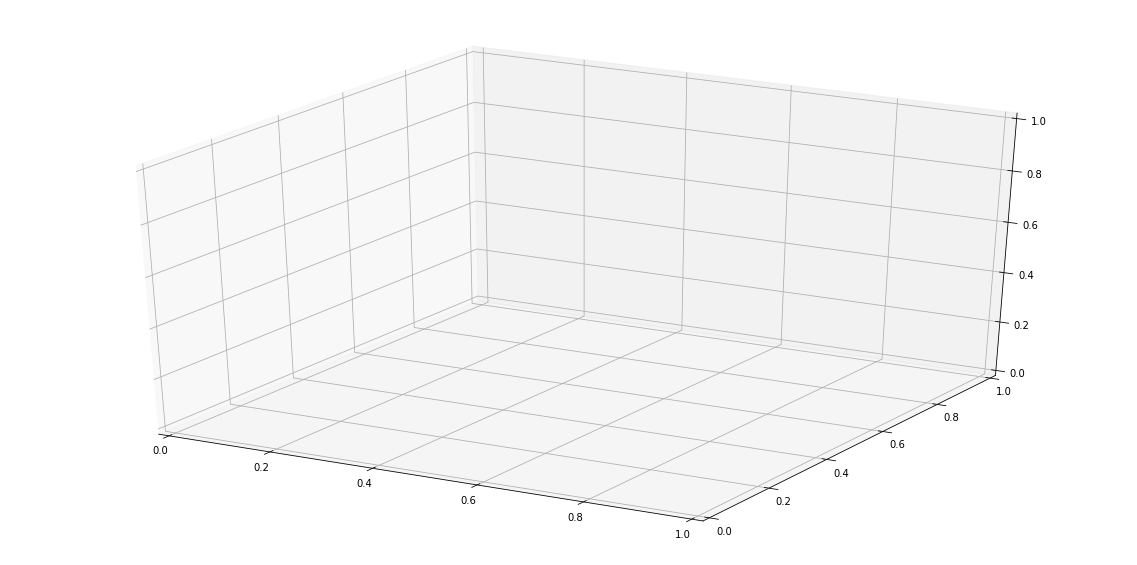

In [42]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Visualize in 3D 
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(LonDD, LatDD, AltDD, label='GPS' )
ax.scatter(longitude[::50],latitude[::50],altitude[::50])

ax.legend()

plt.show()

## Detail View of the Stop

In [ ]:
whratio = np.cos(np.mean(latitude*np.pi/180.0))
fh = 3.0
fig = plt.figure(figsize=(fh/whratio, fh))

# EKF State
plt.plot(lonekf,latekf, label='EKF Position Estimation', color='k', linewidth=3)

# Ground Truth
plt.plot(LonDD,LatDD, label='Ground Truth')

# Low Cost GPS Measurements
plt.scatter(longitude[::50],latitude[::50], s=60, label='GNSS Measurements',\
            c=sp[::50], cmap='winter', norm=matplotlib.colors.LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel(u'Values for $\sigma_x^2$ and $\sigma_y^2$ in $R$', rotation=270)
cbar.ax.set_xlabel(u'$m^2$')

# Annotations
plt.annotate("Vehicle Stop",
            xy=(13.77265, 51.0467), xycoords='data',
            xytext=(13.7726, 51.047), textcoords='data',
            size=14,
            arrowprops=dict(arrowstyle="fancy", #linestyle="dashed",
                            color="0.5",
                            shrinkB=5,
                            connectionstyle="arc3,rad=0.3",
                            ),
            )

plt.xlabel('Longitude [$^\circ$]')
plt.ylabel('Latitude [$^\circ$]')
#plt.title('Position of EKF state $x_k$, GNSS measurements and uncertainty $R$ (color)')
plt.legend(loc='best')
plt.axis('equal')
#plt.tight_layout()

plt.xlim(13.772, 13.773)
plt.ylim(51.0465, 51.0474)

# xticks
locs,labels = plt.xticks()
plt.xticks(locs, map(lambda x: "%.4f" % x, locs))
plt.xticks(rotation=35)

# ytikcs
locs,labels = plt.yticks()
plt.yticks(locs, map(lambda x: "%.4f" % x, locs))

#plt.show()
plt.savefig('Extended-Kalman-Filter-CTRV-Position-Detail.eps', bbox_inches='tight')